In [1]:
from ROOT import TCanvas, TFile
from ROOT import TGraph, TGraphPolar
from ROOT import gStyle
from array import array
import math

c1 = TCanvas( 'c1', 'The Main Canvas', 200, 10, 1000, 800 )
c1.SetGridx()
c1.SetGridy()
c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderMode(-1 )
c1.GetFrame().SetBorderSize( 5 )
c1.Divide(3,1)

Welcome to JupyROOT 6.26/06


In [2]:
def gravrk(x,t,param,deriv):
    GM = param[0]
    r1 = x[0]
    r2 = x[1]
    v1 = x[2]
    v2 = x[3]
    normR = math.sqrt(r1*r1+r2*r2)
    accel1 = -GM*r1/(normR*normR*normR)
    accel2 = -GM*r2/(normR*normR*normR)
    deriv[0] = v1
    deriv[1] = v2
    deriv[2] = accel1
    deriv[3] = accel2

In [3]:
def rk4(x,nX,t,tau,deriv,param):
    F1 = array('d')
    F2 = array('d')
    F3 = array('d')
    F4 = array('d')
    xtemp = array('d')
    
    for i in range(0,nX):
        F1.append(0.0)
        F2.append(0.0)
        F3.append(0.0)
        F4.append(0.0)
        xtemp.append(0.0)
        
    gravrk(x,t,param,F1)
    
    half_tau = 0.5*tau
    t_half = t + half_tau
    
    for i in range(0,nX):
        xtemp[i] = x[i] + half_tau*F1[i]
        
    gravrk(xtemp,t_half,param,F2)
    
    for i in range(0,nX):
        xtemp[i] = x[i] + half_tau*F2[i]
        
    gravrk(xtemp,t_half,param,F3)
    
    t_full = t + tau

    for i in range(0,nX):
        xtemp[i] = x[i] + tau*F3[i]
        
    gravrk(xtemp,t_full,param,F4)
    
    for i in range(0,nX):
        x[i] = x[i] + tau/6.0*(F1[i]+F4[i]+2.0*(F2[i]+F3[i]))

In [4]:
def rka(x,nX,t,tau,err,deriv,param):
    tSave = t
    safe1 = 0.9
    safe2 = 0.2
    
    xSmall = array('d')
    xBig = array('d')
    for i in range(0,nX):
        xSmall.append(0.0)
        xBig.append(0.0)
        
    maxTry = 100
    for iTry in range(0,maxTry):
        half_tau = 0.5*tau
        for i in range(0,nX):
            xSmall[i]=x[i]
        rk4(xSmall,nX,tSave,half_tau,deriv,param)
        t = tSave + half_tau
        rk4(xSmall,nX,t,half_tau,deriv,param)
        
        t = tSave + tau
        for i in range(0,nX):
            xBig[i] = x[i]
        rk4(xBig,nX,tSave,tau,deriv,param)
        
        errorRatio = 0.0
        eps = 1.0E-16
        for i in range(0,nX):
            scale = err * (math.fabs(xSmall[i]) + math.fabs(xBig[i]))/2.0
            xDiff = xSmall[i]-xBig[i]
            ratio = math.fabs(xDiff)/(scale+eps)
            if (errorRatio <= ratio):
                errorRatio = ratio
                
        tau_old = tau
        tau = safe1*tau_old*math.pow(errorRatio,-0.20)
        if (tau <= tau_old/safe2):
            tau = tau_old/safe2
        if (tau >= safe2/tau_old):
            tau = safe2/tau_old
            
        if (errorRatio < 1):
            for i in range(0,nX):
                x[i] = xSmall[i]
            return
        
    print("Error:  Adaptive Runge-Kutta Routine failed")

In [5]:
# Circular Orbit of radius 1 for testing
#
#r0 = 1.0
#v0 = 2.0*math.pi
#
# Earth - circular with zero eccentricity
#
#semi_major = 1.0
#eccentricity = 0.0
#
# Halley's Comet
#
semi_major = 17.834
eccentricity = 0.967

nStep = 77000
tau = 0.01
method = 3

# Everything below this point is calculated.
semi_minor = semi_major*math.sqrt(1-eccentricity*eccentricity)
GMSIUnits = 1.32712442099E+20
SecondsInYear = 31556952
AUnit = 149597870700
GM = GMSIUnits/math.pow(AUnit,3)*math.pow(SecondsInYear,2)
F = math.sqrt((semi_major)**2-(semi_minor)**2)  # distance from centre of the ellipse to focus
r0 = semi_major+F

v0 = math.sqrt(GM*(2/r0-1/semi_major))
print (semi_major,semi_minor,F,GM,r0,v0)

param = array('d')
param.append(GM)
mass = 1.0
adaptErr = 0.001
time = 0.0

17.834 4.543681827715934 17.245478 39.47530582087944 35.079477999999995 0.19270507865654937


In [6]:
r = array('d')
v = array('d')
state = array('d')
accel = array('d')
deriv = array('d')

nState = 4

r.append(r0)
r.append(0.0)
v.append(0.0)
v.append(v0)
accel.append(0.0)
accel.append(0.0)

state.append(r[0])
state.append(r[1])
state.append(v[0])
state.append(v[1])

for i in range(0,nState):
    deriv.append(0.0)

In [7]:
rplot = array('d')
thplot = array('d')
tplot = array('d')
kinetic = array('d')
potential = array('d')
energy = array('d')

In [8]:
for iStep in range(0,nStep):
    normR = math.sqrt(r[0]*r[0]+r[1]*r[1])
    normV = math.sqrt(v[0]*v[0]+v[1]*v[1])
    rplot.append(normR)
    thplot.append(math.atan2(r[1],r[0]))
    tplot.append(time)
    kinetic.append(0.5*mass*normV*normV)
    potential.append(-1.0*GM*mass/normR)
    energy.append(kinetic[iStep]+potential[iStep])
    
    if (method == 1):
        accel[0] = -1.0*GM*r[0]/(normR*normR*normR)
        accel[1] = -1.0*GM*r[1]/(normR*normR*normR)
        r[0] = r[0] + tau*v[0]
        r[1] = r[1] + tau*v[1]
        v[0] = v[0] + tau*accel[0]
        v[1] = v[1] + tau*accel[1]
        time = time + tau
    else:
        if (method == 2):
            accel[0] = -1.0*GM*r[0]/(normR*normR*normR)
            accel[1] = -1.0*GM*r[1]/(normR*normR*normR)
            v[0] = v[0] + tau*accel[0]
            v[1] = v[1] + tau*accel[1]
            r[0] = r[0] + tau*v[0]
            r[1] = r[1] + tau*v[1]
            #print(r[0],r[1],v[0],v[1])
            time = time + tau
        else:
            if (method == 3):
                rk4(state,nState,time,tau,deriv,param)
                r[0]=state[0]
                r[1]=state[1]
                v[0]=state[2]
                v[1]=state[3]
                time = time + tau
            else:
                if (method == 4):
                    rka(state,nState,time,tau,adaptErr,deriv,param)
                    r[0]=state[0]
                    r[1]=state[1]
                    v[0]=state[2]
                    v[1]=state[3]
                    time = time + tau
                    
                

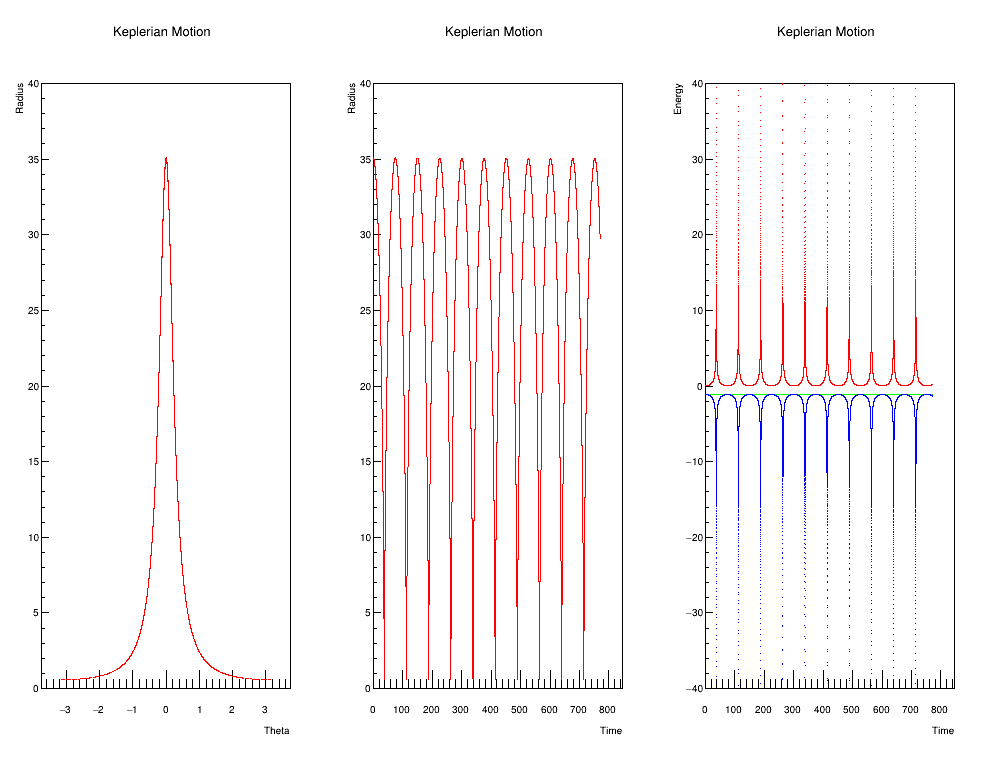

In [9]:
gStyle.SetOptFit(1)
c1.Draw()

grr = TGraph(nStep,thplot,rplot)
#grr = TGraphPolar(nStep,thplot,rplot)
grt = TGraph(nStep,tplot,rplot)
gre = TGraph(nStep,tplot,energy)
grk = TGraph(nStep,tplot,potential)
grp = TGraph(nStep,tplot,kinetic)
grr.SetMarkerColor(2)
grt.SetMarkerColor(2)
gre.SetMarkerColor(3)
grk.SetMarkerColor(4)
grp.SetMarkerColor(2)

#print (rplot)

c1.cd(1)
grr.GetHistogram().SetMaximum(40.0)
grr.GetHistogram().SetMinimum(0.0)
#grr.SetMarkerStyle(22)
grr.SetTitle("Keplerian Motion")
grr.GetXaxis().SetTitle("Theta")
grr.GetYaxis().SetTitle("Radius")
grr.Draw("AP")

c1.cd(2)
grt.GetHistogram().SetMaximum(40.0)
grt.GetHistogram().SetMinimum(0.0)
#grt.SetMarkerStyle(22)
grt.SetTitle("Keplerian Motion")
grt.GetXaxis().SetTitle("Time")
grt.GetYaxis().SetTitle("Radius")
grt.Draw("AP")

c1.cd(3)
gre.GetHistogram().SetMaximum(40.0)
gre.GetHistogram().SetMinimum(-40.0)
#gre.SetMarkerStyle(22)
#grk.SetMarkerStyle(22)
#grp.SetMarkerStyle(22)
gre.SetTitle("Keplerian Motion")
gre.GetXaxis().SetTitle("Time")
gre.GetYaxis().SetTitle("Energy")
gre.Draw("AP")
grk.Draw("P")
grp.Draw("P")
c1.Draw()